In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import albumentations as A
import cv2
import interpretability_toolkit.attributions as attr
import matplotlib.pyplot as plt
import timm
import torch
from albumentations.pytorch import ToTensorV2
from interpretability_toolkit.utils.plots import plot_images_heatmaps
from timm.data.constants import (
    IMAGENET_DEFAULT_MEAN,
    IMAGENET_INCEPTION_STD,
)

Attribution = attr.Attribution


In [13]:
path = f'ClementP/FundusDRGrading-vit_large_patch14_reg4_dinov2.lvd142m'
model = timm.create_model(f'hf_hub:{path}', pretrained=True, img_size=512, num_classes=1)


In [14]:
img = cv2.imread("fundus.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_CUBIC),
                       A.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_INCEPTION_STD), ToTensorV2()])
img = transform(image=img)["image"].unsqueeze(0)


Generating heatmap with method:  attention_rollout
Generating heatmap with method:  chefer
Generating heatmap with method:  focused_attention


100%|██████████| 14/14 [00:04<00:00,  3.08it/s]


Restoring the model to its original state.


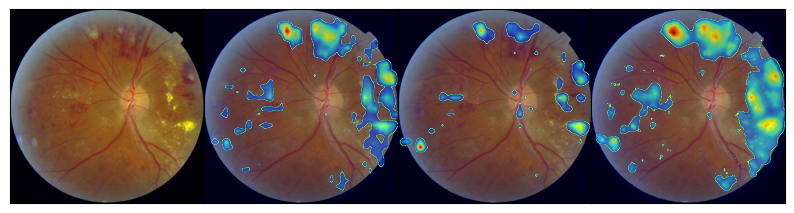

In [19]:
model = model.cuda(0)
attr = Attribution(model, sampling_points=1024, with_replacement=False, temperature=1.2, dilate_tokens=False, 
                   attribution_method='rollout', noise_level=.5) 

img = img.cuda(0)

methods = ["attention_rollout", "chefer", 
           "focused_attention"
           ]
attributions = []
for m in methods:
    print("Generating heatmap with method: ", m)
    with torch.no_grad():
        pred = model(img)
    pred = torch.round(pred)
    head_fusion = "mean" if m == "chefer" else "min"
    with torch.autocast('cuda'):

        a = attr.attribute(img, method=m, output=pred, discard_ratio=0.5, start_from=0,
                                        as_regression=True, 
                                    head_fusion=head_fusion)
    attributions.append(torch.nan_to_num(a, nan=0.0))

fig = plot_images_heatmaps(img, attributions, border_width=3, cmap='jet', threshold='otsu', use_sigmoid=True)

plt.savefig("vit_attributions.png", bbox_inches='tight', pad_inches=0, dpi=300)


In [20]:
path = f'ClementP/FundusDRGrading-convnext_base'
model = timm.create_model(f'hf_hub:{path}', pretrained=True, num_classes=1)


Generating heatmap with method:  guided_gradcam
Generating heatmap with method:  ig
Generating heatmap with method:  deep_lift


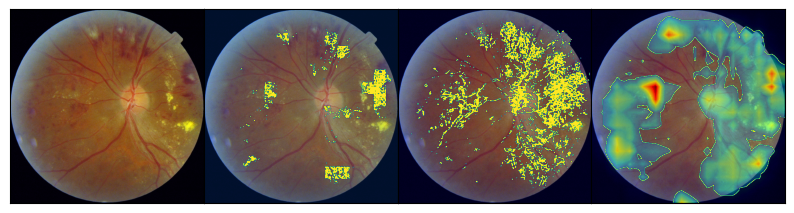

In [24]:
model = model.cuda(0)
attr = Attribution(model, sampling_points=512, with_replacement=False, temperature=1.2, dilate_tokens=False, 
                   attribution_method='rollout', noise_level=1.5) 

img = img.cuda(0)

methods = [ 
           "guided_gradcam",
           "ig", "deep_lift"
           ]
attributions = []
for m in methods:
    print("Generating heatmap with method: ", m)
    with torch.autocast('cuda'):
        a = attr.attribute(img, method=m)
        attributions.append(torch.nan_to_num(a, nan=0.0))

fig = plot_images_heatmaps(img, attributions, border_width=3, cmap='jet', threshold='otsu', use_sigmoid=False)

plt.savefig("convnext_attributions.png", bbox_inches='tight', pad_inches=0, dpi=300)
